In [ ]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc

from pathlib import Path
base_path = Path('/content/drive/MyDrive/zadanie-ml/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

---
# 0. Importowanie danych treningowych i testowych
---
Do danych treningowych trafia ok. 80% bazy, 20% przeznaczone zostanie do testów.

In [ ]:
train_data = pd.read_csv(base_path / 'titanic_final_train.csv', index_col='PassengerId')
train_data

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,
1,0,1,22.0,1,1,0
2,1,0,38.0,2,1,0
3,1,0,26.0,1,0,0
4,1,0,35.0,1,1,0
5,0,1,35.0,1,0,0
...,...,...,...,...,...,...
708,1,1,42.0,1,0,0
709,1,0,22.0,1,0,0
710,1,1,29.0,2,2,0


In [ ]:
test_data = pd.read_csv(base_path / 'titanic_final_test.csv', index_col='PassengerId')
test_data

,Survived,Sex,Age,Embarked,Family,Underage
PassengerId,,,,,,
713,1,1,48.0,1,1,0
714,0,1,29.0,1,0,0
715,0,1,52.0,1,0,0
716,0,1,19.0,1,0,0
717,1,0,38.0,2,0,0
...,...,...,...,...,...,...
887,0,1,27.0,1,0,0
888,1,0,19.0,1,0,0
889,0,0,27.0,1,3,0


---
# 1. Analiza danych z poprzedniego zadania i przedstawienie wniosków
---

# 1.1 Rozkłady podobieństwa

In [ ]:
def mle_plot_normal(data, title):
  mle_mu = np.mean(data)
  mle_sigma = np.std(data, ddof=0)

  x = np.linspace(10, 50, 1000)
  pdf = sc.norm.pdf(x, mle_mu, mle_sigma)

  plt.figure(figsize=(8, 4))
  sns.histplot(data, bins=50, stat="density", color="green", alpha=0.2, label="Dane (histogram)")
  plt.plot(x, pdf, color='darkgreen', lw=2, label='Rozkład dopasowany (MLE)')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

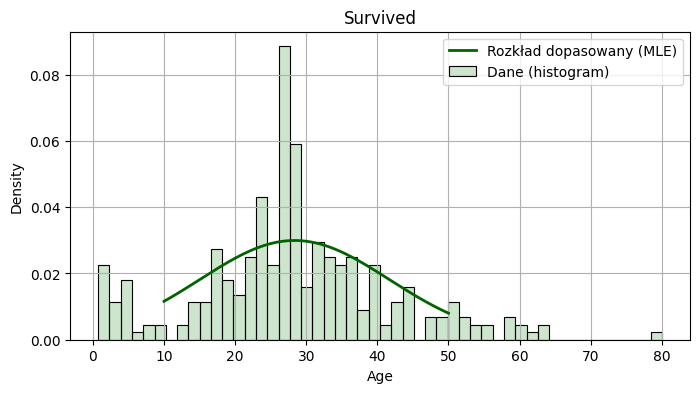

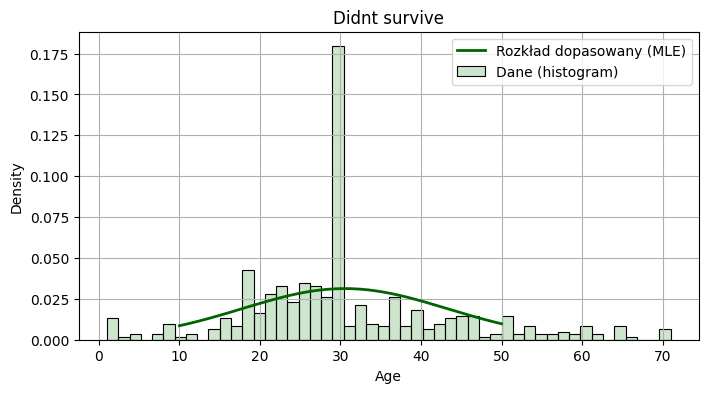

In [ ]:
survived_data = train_data[train_data['Survived'] == 1]

mle_plot_normal(survived_data['Age'], 'Survived')

not_survived_data = train_data[train_data['Survived'] == 0]

mle_plot_normal(not_survived_data['Age'], 'Didnt survive')



W zasadzie mało z tego wiemy, jedynie widać tu w dalszej części wykresów, że większość ludzi powyżej pewnego wieku nie przeżyła, z wyjątkiem jednej osoby.

# 1.2. Zastosowanie twierdzenia Bayesa

Tworzymy funkcję wyliczającą a posteriori według twierdzenia Bayesa.
Przyjmuje zmienne:
- data: dane, z których korzystamy
- ap_parameter: kolumna danych, dla której wyznaczamy a priori, np. 'Survived'
- ap_condition: wartość, którą mają przyjmować dane w a priori, np. 1 (True)
- data_parameter: kolumna danych, dla których wyznaczamy prawdopodobieństwo całkowite razem z kolumną ap_parameter, np. 'Sex'
- data_condition: wartość, którą mają przyjmować dane w prawdopodobieństwie całkowitym, np. 1 (mężczyzna)

Z przykładowymi zmiennymi funkcja wyznacza prawdopodobieństwo, że pasażer będący mężczyzną przetrwał

In [ ]:
def bayes(data, ap_parameter, ap_condition, data_parameter, data_condition):
  # Wyznaczenie a_priori
  a_priori = (data[ap_parameter] == ap_condition).mean()
  neg_a_priori = 1 - a_priori

  # Wyznaczenie prawdopodobieństwa całkowitego spełnienia warunków ap_condition + data_condition
  prob_t_data = data[data[ap_parameter] == ap_condition]
  prob_t = (prob_t_data[data_parameter] == data_condition).mean()
  prob_f_data = data[data[ap_parameter] != ap_condition]
  prob_f = (prob_f_data[data_parameter] == data_condition).mean()

  # Wyznaczenie prawdopodobieństwa całkowite
  total_prob = prob_t * a_priori + prob_f * neg_a_priori

  # Twierdzenie Bayesa
  p_ap_condition = prob_t * a_priori / total_prob

  return round(p_ap_condition, 2)

# Twierdzenie bayesa dla warunku data parameter >= data_condition
def bayes_above(data, ap_parameter, ap_condition, data_parameter, data_condition):
  # Wyznaczenie a_priori
  a_priori = (data[ap_parameter] == ap_condition).mean()
  neg_a_priori = 1 - a_priori

  # Wyznaczenie prawdopodobieństwa całkowitego spełnienia warunków ap_condition + data_condition
  prob_t_data = data[data[ap_parameter] == ap_condition]
  prob_t = (prob_t_data[data_parameter] >= data_condition).mean()
  prob_f_data = data[data[ap_parameter] != ap_condition]
  prob_f = (prob_f_data[data_parameter] >= data_condition).mean()

  # Wyznaczenie prawdopodobieństwa całkowite
  total_prob = prob_t * a_priori + prob_f * neg_a_priori

  # Twierdzenie Bayesa
  p_ap_condition = prob_t * a_priori / total_prob

  return round(p_ap_condition, 2)



In [ ]:
print("Prawdopodobieństwo, że mężczyzna przetrwał: ", bayes(train_data, 'Survived', 1, 'Sex', 1))
print("Prawdopodobieństwo, że kobieta przetrwała: ", bayes(train_data, 'Survived', 1, 'Sex', 0))
print("Prawdopodobieństwo, że dziecko przetrwało: ", bayes(train_data, 'Survived', 1, 'Underage', 1))
print("Prawdopodobieństwo, że dorosły przetrwał: ", bayes(train_data, 'Survived', 1, 'Underage', 0))
#Rodzina
print("\nPrawdopodobieństwo, że pasażer bez rodziny na pokładzie przetrwał: ", bayes(train_data, 'Survived', 1, 'Family', 0))
print("Prawdopodobieństwo, że pasażer z rodziną na pokładzie przetrwał: ", bayes_above(train_data, 'Survived', 1, 'Family', 1))
print("Prawdopodobieństwo, że pasażer z dużą rodziną (>=4) na pokładzie przetrwał: ", bayes_above(train_data, 'Survived', 1, 'Family', 4))

Prawdopodobieństwo, że mężczyzna przetrwał:  0.19
Prawdopodobieństwo, że kobieta przetrwała:  0.74
Prawdopodobieństwo, że dziecko przetrwało:  0.54
Prawdopodobieństwo, że dorosły przetrwał:  0.37

Prawdopodobieństwo, że pasażer bez rodziny na pokładzie przetrwał:  0.32
Prawdopodobieństwo, że pasażer z rodziną na pokładzie przetrwał:  0.49
Prawdopodobieństwo, że pasażer z dużą rodziną (>=4) na pokładzie przetrwał:  0.16


# 1.3. Regresja wielomianowa

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# Regresja wielomianowa
def polynomial_regression(X, y, deg, header):
  # Model wielomianowy
  poly_model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
  poly_model.fit(X, y)
  y_pred = poly_model.predict(X)

  # Wykres
  plt.figure(figsize=(8, 4))
  plt.scatter(X, y, s=10, label='Dane')
  plt.plot(X, y_pred, color='red', lw=2, label='Regresja wielomianowa')
  plt.title(header)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()
  plt.grid(True)
  plt.show()

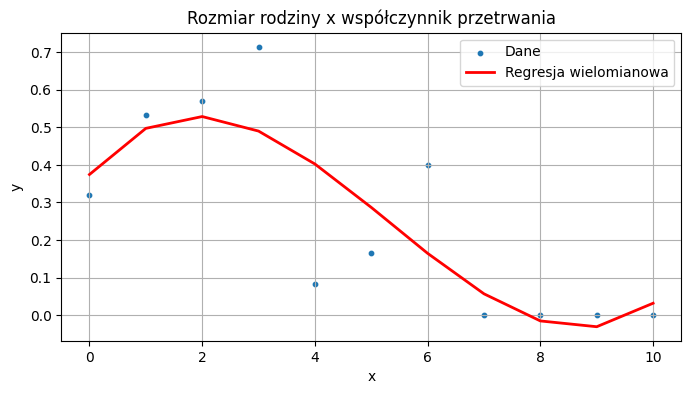

In [ ]:
# Compute survival rate per family
family_survival_rate = train_data.groupby('Family')['Survived'].mean()

family_sizes = list(range(0, train_data['Family'].max()+1))
family_survival_rate = family_survival_rate.reindex(family_sizes, fill_value=0)

X = np.array(family_sizes).reshape(-1, 1)
y = family_survival_rate

polynomial_regression(X, y, 3, "Rozmiar rodziny x współczynnik przetrwania")

Widzimy, że współczynnik przetrwania względem wielkości rodziny z początku rośnie, a później zaczyna maleć.

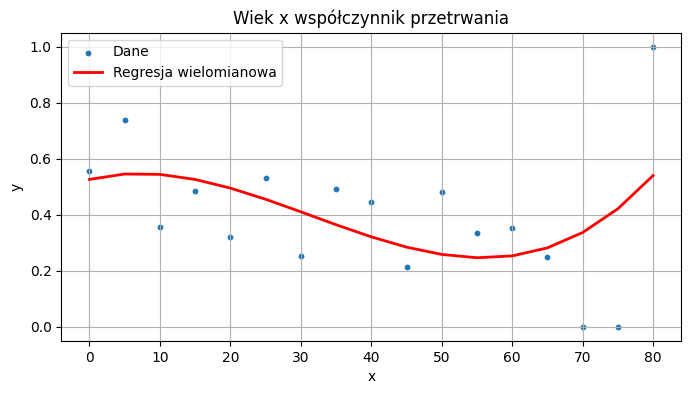

In [ ]:
def age_x_survival_rate(n):
  # Zaokrąglenie wieku do najbliższej wielokrotności n dla przejrzystości wykresu
  age_rounded = (train_data['Age'] / n).round() * n

  # Obliczenie ułamka przetrwania dla grup wiekowych
  age_survival_rate = train_data.groupby(age_rounded)['Survived'].mean()

  age_min = int(age_rounded.min())
  age_max = int(age_rounded.max())
  age_range = list(range(age_min, age_max + n, n))
  age_survival_rate = age_survival_rate.reindex(age_range, fill_value=0)

  X = np.array(age_range).reshape(-1, 1)
  y = age_survival_rate.values

  # Regresja wielomianowa
  polynomial_regression(X, y, 3, "Wiek x współczynnik przetrwania")

age_x_survival_rate(5)

Regresja wielomianowa współczynnika przetrwania względem wieku pokazuje nam, że maleje on, jednak nie jest to w pełni wyraźne przez wartość outlinera dla najwyższego przedziału wieku

W następnym kroku zmniejszam zaokrąglenie przedziałów wieku, dzięki czemu regresja wygląda tak, jak powinna

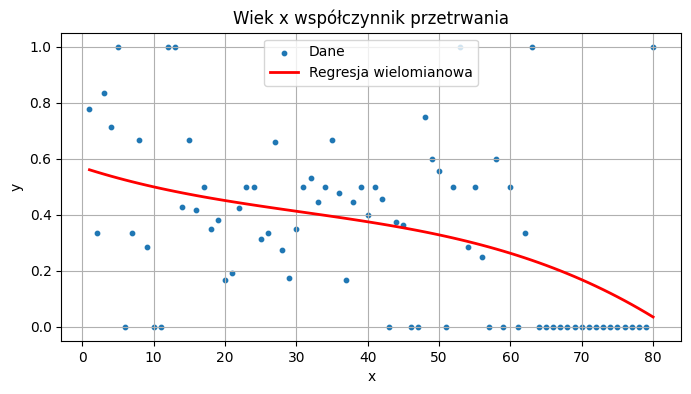

In [ ]:
age_x_survival_rate(1)

Wartości wieku powyżej 65 występują rzadko, ale jeśli już, wiążą się z niską przeżywalnością.

# Podsumowując
Z twierdzenia Bayesa:
- mężczyźni mają drastycznie mniejszą szansę na przetrwanie od kobiet

Z regresji wielomianowej:
- wiek ma wpływ na przetrwanie: im wyższy, tym niższy współczynnik
- rozmiar rodziny ma wpływ na przetrwanie: duże rodziny mają niższy współczynnik

---

# 2. Modele uczenia maszynowego

---

# 2.1. Regresja logistyczna


In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
def LR(X, y):
  # Model
  lr = LogisticRegression()
  lr.fit(X, y)

  X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
  y_prob = lr.predict_proba(X_range)[:, 1]

  sns.regplot(x=X, y=y, logistic=True, ci=None)

Wiek x współczynnik przetrwania

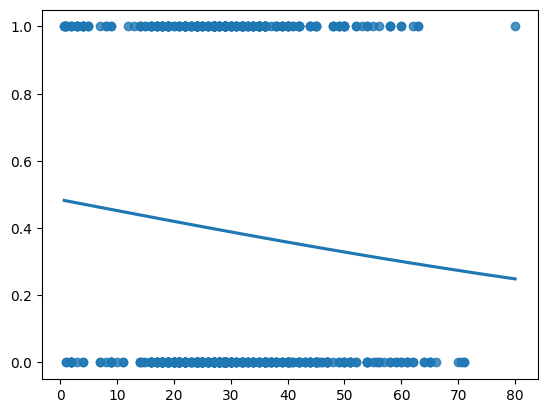

In [ ]:
X = train_data[['Age']].values
y = train_data['Survived'].values

LR(X, y)

Widać regresję w sposób podobny do tej na wykresach regresji liniowej.

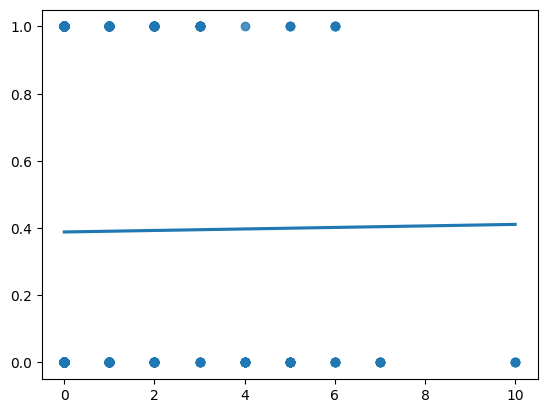

In [ ]:
X = train_data[['Family']].values
y = train_data['Survived'].values

LR(X, y)

Regresja logistyczna względem wielkości rodziny nie pokazuje wyraźnej różnicy, możliwe więc że w tym modelu będzie ona miała małe znaczenie.

# 2.2 Drzewa decyzyjne

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
def dt(X, y):
  tree = DecisionTreeClassifier(max_depth=5, random_state=42)
  tree.fit(X, y)
  plot_tree(tree, filled=True)

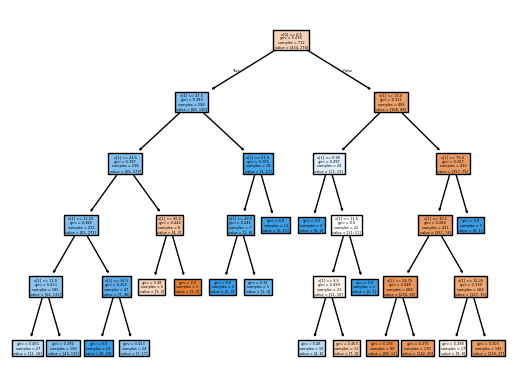

In [ ]:
X = train_data[['Sex', 'Age']].values
y = train_data['Survived'].values

dt(X, y)

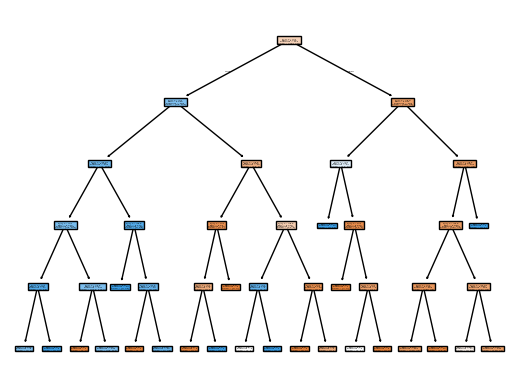

In [ ]:
X = train_data[['Family', 'Sex', 'Age']].values
y = train_data['Survived'].values

dt(X, y)

Mało niestety widać na wykresach drzew przez ilość parametrów, ale możemy zauważyć zależność liczby parametrów i skomplikowania, czyli powinno działać dobrze.



---
# 3. Testy
---

# 3.1. DummyClassifier

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# dane

X_train = train_data[['Sex', 'Age', 'Family']].values
y_train = train_data['Survived'].values
X_test = test_data[['Sex', 'Age', 'Family']].values
y_test = test_data['Survived'].values

In [ ]:
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train) # uczenie
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.64      0.51      0.57       115
           1       0.36      0.48      0.41        64

    accuracy                           0.50       179
   macro avg       0.50      0.50      0.49       179
weighted avg       0.54      0.50      0.51       179



array([[59, 56],
       [33, 31]])

Dokładność średnio ok. 0.5

# 3.2. Drzewa decyzyjne

In [ ]:
# dane

X_train = train_data[['Sex', 'Age', 'Family']].values
y_train = train_data['Survived'].values
X_test = test_data[['Sex', 'Age', 'Family']].values
y_test = test_data['Survived'].values

In [ ]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X, y)
model.fit(X_train, y_train) # uczenie
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       115
           1       0.80      0.77      0.78        64

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.85      0.85      0.85       179



array([[103,  12],
       [ 15,  49]])

Dokładność 0.85

Co więcej dokładność była równa 0.81, gdy rozmiar rodziny nie był brany pod uwagę. Myślę, że jest to na tyle duża różnica, żeby uznać, że ma znaczenie.

# 3.3. Regresja logistyczna

In [ ]:
# dane

X_train = train_data[['Sex', 'Age']].values
y_train = train_data['Survived'].values
X_test = test_data[['Sex', 'Age']].values
y_test = test_data['Survived'].values

In [ ]:
model = LogisticRegression()
model.fit(X, y)
model.fit(X_train, y_train) # uczenie
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.83      0.87      0.85       115
           1       0.74      0.67      0.70        64

    accuracy                           0.80       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



array([[100,  15],
       [ 21,  43]])

Dokładność 0.80, biorąc pod uwagę również rozmiar rodziny, dochodziło do dokładności 0.81.

Można więc wywnioskować, że znaczenie tej zmiennej jest małe, a model będzie prostszy bez niej.

In [ ]:
# Własne próbki

sample = np.array([[1, 90, 2]])
prediction = model.predict(sample)
print("Przewidywania:", prediction[0])

sample = np.array([[1, 220, 10]])
prediction = model.predict(sample)
print("Przewidywania:", prediction[0])

sample = np.array([[0, 28, 4]])
prediction = model.predict(sample)
print("Przewidywania:", prediction[0])

Przewidywania: 1
Przewidywania: 1
Przewidywania: 0


Już widać, że absurdalnie wysokie wartości wieku skutkują zawsze predykcją o wartości 1.

Granicą wielkości rodziny jest 3/4, ale im więcej szans na przetrwanie wyliczono przy pomocy wieku, tym większy jest limit.

Model mógłby zostać ulepszony przez pozbycie się outlinera (80-latek który przeżył) z danych do uczenia.